In [193]:
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import pandas as pd

from skimage.external import tifffile
from skimage import feature, filters
from numpy import genfromtxt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.externals import joblib
import datetime

# Load Data

In [180]:
y = pd.read_csv('/Users/sean/Desktop/onehot.csv', usecols=[1]).values.ravel()
X = pd.read_csv('/Users/sean/Desktop/com_feats.csv', header=None)

In [181]:
hogs = pd.read_csv('/Users/sean/Desktop/hogs.csv')

In [182]:
X = np.concatenate((X, hogs), axis=1)

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [194]:
def save_classifier(clf, X, y, y_test, y_pred):
    date = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
    
    import os, errno
    directory = 'classifiers/{date}'.format(date=date)

    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    
    joblib.dump(clf, 'classifiers/{date}/{date}.pkl'.format(date=date))
    
    report = "Classification Report\nAccuracy Score: {acc}\n{class_report}".format(
        acc=metrics.accuracy_score(y_test, y_pred),
        class_report=metrics.classification_report(y_test, y_pred))
    
    with open(directory + '/report.txt', 'w') as f:
        f.write(report)
    plot_confusion_matrix(y_test, y_pred, np.unique(y), normalize=True, outFileDirName=directory)
    

def show_pca_2d(X, y, ax=None):
    pca = PCA(n_components=3).fit_transform(X)
    
    if not ax:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)

    for l, c, m in zip([0, 1], ('blue', 'red'), ('^', 's')):
        ax.scatter(pca[y == l, 0], pca[y == l, 1], color=c, label='class %s' % l, alpha=0.5, marker=m)
    return ax
    
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, outFileDirName=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if outFileDirName:
        plt.savefig(outFileDirName + '/confusion_matrix.pdf')

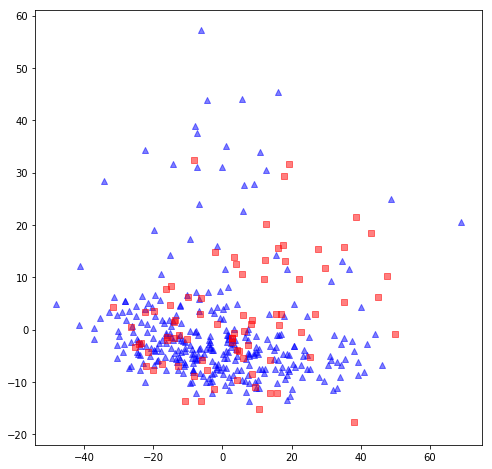

In [226]:
show_pca_2d(X_test, y_test)

In [227]:
clf = AdaBoostClassifier(n_estimators=100)
# clf = KNeighborsClassifier(n_neighbors=1)
# clf = SVC(gamma=3, C=5)
#
y_pred = clf.fit(X_train_std, y_train).predict(X_test_std)
# show_mislabelled_pca(X_train, y_pred, y_train)

Normalized confusion matrix
[[0.93015873 0.06984127]
 [0.40740741 0.59259259]]


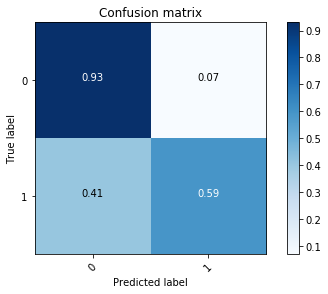

In [228]:
plot_confusion_matrix(y_test, y_pred, range(2), normalize=True)

In [229]:
metrics.accuracy_score(y_test, y_pred)

0.8611111111111112

In [191]:
s = metrics.classification_report(y_test, y_pred)
print(s)

             precision    recall  f1-score   support

          0       0.90      0.93      0.91       315
          1       0.69      0.59      0.64        81

avg / total       0.86      0.86      0.86       396



Normalized confusion matrix
[[0.98579545 0.01420455]
 [0.34090909 0.65909091]]


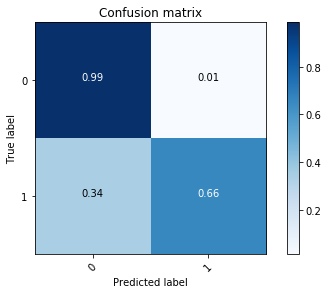

In [179]:
save_classifier(clf, X, y, y_test, y_pred)

In [199]:
np.savetxt('/Users/sean/Desktop/temp.csv', X_train_std, delimiter=',')

In [216]:
pca = PCA(n_components=3).fit_transform(X_train_std)

In [217]:
np.savetxt('/Users/sean/Desktop/pca.csv', np.concatenate((y_train.reshape((len(y_train), 1)), pca), axis=1), delimiter=',')